# Benchmarking Results

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

### 1. Load, Summarize, Insert

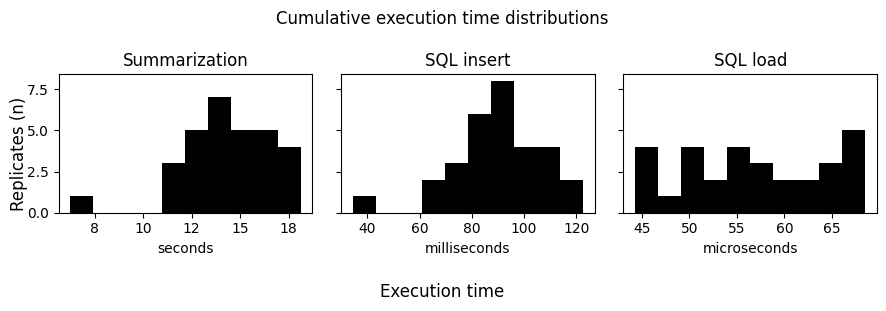

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   replicate                 30 non-null     int64  
 1   num_abstracts             30 non-null     int64  
 2   total_replicate_time      30 non-null     float64
 3   total_summarization_time  30 non-null     float64
 4   total_insert_time         30 non-null     float64
 5   total_loading_time        30 non-null     float64
 6   mean_total_time           30 non-null     float64
 7   mean_summarization_time   30 non-null     float64
 8   mean_insert_time          30 non-null     float64
 9   mean_loading_time         30 non-null     float64
dtypes: float64(8), int64(2)
memory usage: 2.5 KB


In [2]:
data = pd.read_csv('../benchmarks/load_summarize_insert/results.csv')

titles = ['Summarization', 'SQL insert', 'SQL load']
data_types = ['mean_summarization_time', 'mean_insert_time', 'mean_loading_time']
xlabels = ['seconds', 'milliseconds', 'microseconds']
xaxis_scales = [1, 10**3, 10**6]

fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True, tight_layout=True)

fig.suptitle('Cumulative execution time distributions')
fig.supxlabel('Execution time')
fig.supylabel('Replicates (n)')

axs_num = 0

for title, data_type, xlabel, xaxis_scale in zip(titles, data_types, xlabels, xaxis_scales):

    axs[axs_num].set_title(title)
    axs[axs_num].set_xlabel(xlabel)
    axs[axs_num].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    axs[axs_num].hist(
        data[data_type] * xaxis_scale,
        histtype='stepfilled', 
        cumulative=0,
        color='black'
    )

    axs_num += 1

plt.show()

data.info()

In [3]:
data.head()

,replicate,num_abstracts,total_replicate_time,total_summarization_time,total_insert_time,total_loading_time,mean_total_time,mean_summarization_time,mean_insert_time,mean_loading_time
0,1,5,91.137909,90.621423,0.516188,0.000299,18.227582,18.124285,0.103238,0.000060
1,2,5,81.190633,80.775728,0.414573,0.000333,16.238127,16.155146,0.082915,0.000067
2,3,5,61.206696,60.843378,0.363094,0.000224,12.241339,12.168676,0.072619,0.000045
3,4,5,81.342521,80.803011,0.539262,0.000247,16.268504,16.160602,0.107852,0.000049
4,5,5,88.175071,87.580209,0.594577,0.000284,17.635014,17.516042,0.118915,0.000057


### 2. Huggingface Device Map

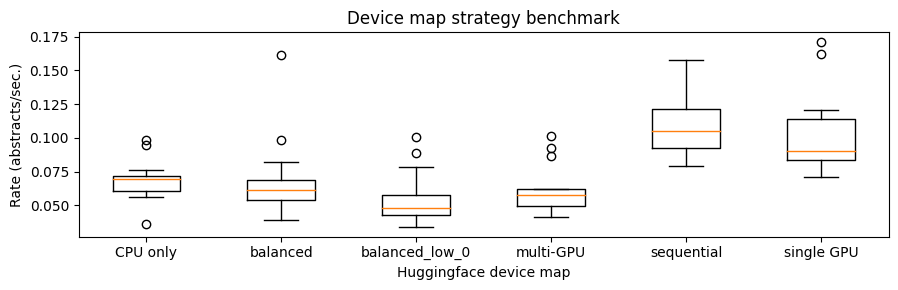

,abstract,device map strategy,summarization time (sec.),summarization rate (abstracts/sec.)
0,1,CPU only,27.611567,0.036217
1,2,CPU only,16.454564,0.060773
2,3,CPU only,13.135237,0.076131
3,4,CPU only,14.419200,0.069352
4,5,CPU only,14.056253,0.071143


In [63]:
data = pd.read_csv('../benchmarks/huggingface_device_map/results.csv')
wide_data = data.pivot(index='abstract', columns='device map strategy', values='summarization rate (abstracts/sec.)')

fig, axs = plt.subplots(1, 1, figsize=(9, 3), tight_layout=True)

axs.set_title('Device map strategy benchmark')
axs.set_xlabel('Huggingface device map')
axs.set_ylabel('Rate (abstracts/sec.)')
axs.boxplot(wide_data, labels=wide_data.columns)

plt.show()

data.head()

### 3. Parallel Summarization

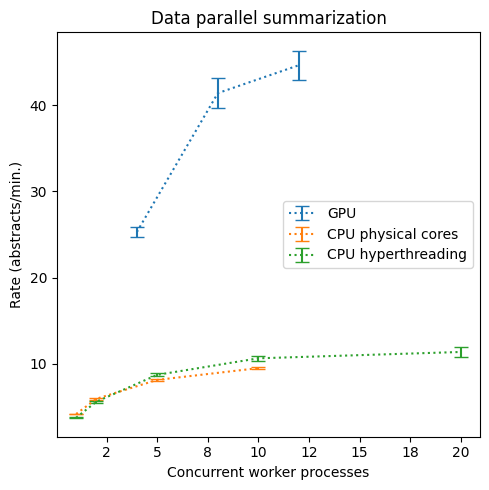

,replicate,abstracts,abstracts per worker,workers,device map strategy,summarization time (sec.),summarization rate (abstracts/sec.),summarization rate (abstracts/min.)
0,0,120,30,4,GPU,280.046850,0.428500,25.709984
1,1,120,30,4,GPU,292.025422,0.410923,24.655388
2,2,120,30,4,GPU,283.045286,0.423960,25.437626
3,3,120,30,4,GPU,277.615275,0.432253,25.935172
4,4,120,30,4,GPU,290.920466,0.412484,24.749032


In [60]:
data = pd.read_csv('../benchmarks/parallel_summarize/results.csv')
data['summarization rate (abstracts/min.)'] = data['summarization rate (abstracts/sec.)'] * 60

device_map_strategies = ['GPU', 'CPU physical cores', 'CPU hyperthreading']

fig, axs = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)

axs.set_title('Data parallel summarization benchmark')
axs.set_xlabel('Concurrent worker processes')
axs.set_ylabel('Rate (abstracts/min.)')
axs.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

for device_map_strategy in device_map_strategies:

    plot_data = data[data['device map strategy'] == device_map_strategy]

    mean = plot_data.groupby(['device map strategy', 'workers']).mean()
    mean.reset_index(inplace=True)
    
    std = plot_data.groupby(['device map strategy', 'workers']).std()
    std.reset_index(inplace=True)

    axs.errorbar(
        mean['workers'], 
        mean['summarization rate (abstracts/min.)'], 
        yerr=std['summarization rate (abstracts/min.)'],
        capsize=5,
        label=device_map_strategy,
        linestyle='dotted'
    )

plt.legend(loc='center right')
plt.show()

data.head()

### 4. SQL Insert

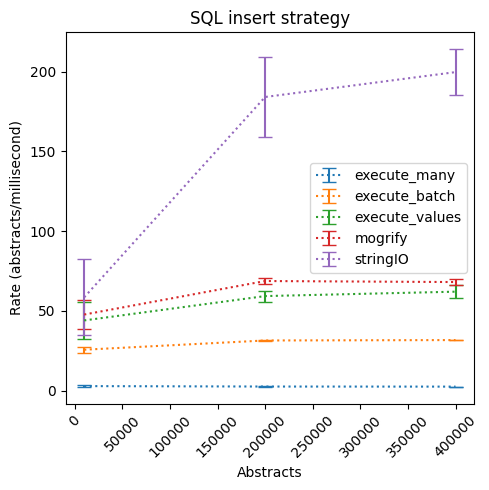

,abstracts,insert time (sec.),insert rate (abstracts/sec.),insert strategy,replicate,insert rate (abstracts/millisecond)
0,10000,4.011200,2493.019576,execute_many,1,2.493020
1,10000,4.058270,2464.103887,execute_many,2,2.464104
2,10000,3.886749,2572.844594,execute_many,3,2.572845
3,10000,4.013787,2491.413000,execute_many,4,2.491413
4,10000,3.047673,3281.191670,execute_many,5,3.281192


In [61]:
data = pd.read_csv('../benchmarks/sql_insert/results.csv')
data['insert rate (abstracts/millisecond)'] = data['insert rate (abstracts/sec.)'] / 1000

insert_strategies = ['execute_many', 'execute_batch', 'execute_values', 'mogrify', 'stringIO']

fig, axs = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)

axs.set_title('SQL insert benchmark')
axs.set_xlabel('Abstracts')
axs.set_ylabel('Rate (abstracts/millisecond)')
axs.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
axs.tick_params(axis='x', labelrotation=45)

for insert_strategy in insert_strategies:

    plot_data = data[data['insert strategy'] == insert_strategy]

    mean = plot_data.groupby(['insert strategy', 'abstracts']).mean()
    mean.reset_index(inplace=True)
    
    std = plot_data.groupby(['insert strategy', 'abstracts']).std()
    std.reset_index(inplace=True)

    axs.errorbar(
        mean['abstracts'], 
        mean['insert rate (abstracts/millisecond)'], 
        yerr=std['insert rate (abstracts/millisecond)'],
        capsize=5,
        label=insert_strategy,
        linestyle='dotted'
    )

plt.legend(loc='center right')
plt.show()

data.head()